# End-to-End Variable Selection for Logistic Regression
## Ensemble Methods with Nested Cross-Validation

This notebook implements a comprehensive variable selection pipeline for fair lending logistic regression models, incorporating:

1. **Data Preparation & Profiling**
2. **Assumption Pre-Screening** (EPV, separation checks)
3. **Filter Methods** (IV, Mutual Information, Correlation)
4. **Multicollinearity Assessment** (VIF)
5. **Nested CV with Ensemble Selection** (LASSO, Elastic Net, RFE, Forward Selection, Tree Importance)
6. **Assumption Validation** (Linearity in logit, VIF on final set)
7. **Final Model Diagnostics**

---

## 1. Setup and Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Import our custom utilities
from variable_selection_utils import (
    # Data generation
    generate_fair_lending_data,
    
    # Assumption validation
    calculate_epv,
    calculate_vif,
    iterative_vif_elimination,
    check_separation,
    box_tidwell_test,
    
    # Filter methods
    calculate_all_iv,
    calculate_mutual_information,
    correlation_filter,
    
    # Selection methods
    lasso_selection,
    elastic_net_selection,
    rfe_selection,
    forward_selection,
    mutual_info_selection,
    tree_importance_selection,
    iv_selection,
    
    # Nested CV
    NestedCVVariableSelector,
    
    # Diagnostics and visualization
    final_model_diagnostics,
    plot_feature_importance_comparison,
    plot_stability_across_folds,
    plot_cv_performance
)

print("All imports successful!")

All imports successful!


---
## 2. Generate Fair Lending Dataset

We generate a synthetic dataset with realistic fair lending attributes including:
- Credit characteristics (score, utilization, delinquencies)
- Loan characteristics (amount, LTV, interest rate)
- Employment information
- Noise features (to test selection robustness)
- Correlated features (to test multicollinearity handling)

In [2]:
# Generate dataset
RANDOM_STATE = 42
N_SAMPLES = 10000
exclude_cols = ['application_date']  # Exclude date column from certain checks

_X, y = generate_fair_lending_data(
    n_samples=N_SAMPLES,
    random_state=RANDOM_STATE,
    default_rate=0.15,
    n_noise_features=10
)

print(f"\nDataset shape: {_X.shape}")
print(f"Target distribution:")
print(pd.Series(y).value_counts(normalize=True))

X = _X.drop(columns=exclude_cols)  # Drop date column for now

Generated dataset: 10000 samples, 34 features
Default rate: 4.34%
Date distribution:
application_date
2021    2000
2022    2000
2023    2000
2024    2000
2025    2000
Name: count, dtype: int64

Dataset shape: (10000, 34)
Target distribution:
0   0.9566
1   0.0434
Name: proportion, dtype: float64


In [3]:
# Quick data overview
desc = X.describe(include='all').T

# Add unique levels for each variable
desc['n_unique'] = X.nunique()

# Add data type for each variable
desc['dtype'] = X.dtypes.astype(str)

desc

,count,mean,std,min,25%,50%,75%,max,n_unique,dtype
credit_score,10000.0000,679.3249,79.0256,366.2080,626.1928,679.7924,733.6865,850.0000,9836,float64
dti_ratio,10000.0000,24.9601,13.7159,10.0007,14.4668,20.7392,31.2328,65.0000,9723,float64
ltv_ratio,10000.0000,77.8467,11.4773,50.0000,69.7146,77.9721,86.0812,100.0000,9587,float64
annual_income,10000.0000,67307.4990,36010.3511,20000.0000,42029.0534,59371.0726,83687.0347,386125.0935,9860,float64
loan_amount,10000.0000,235436.0985,139924.4487,50000.0000,136205.1632,202939.3277,296753.0657,1000000.0000,9934,float64
employment_length,10000.0000,4.9611,4.9085,0.0002,1.4595,3.4608,6.9744,40.0000,9999,float64
employment_type,10000.0000,1.9738,0.5221,0.0000,2.0000,2.0000,2.0000,3.0000,4,int64
num_delinquencies,10000.0000,0.5026,0.7095,0.0000,0.0000,0.0000,1.0000,5.0000,6,int32
months_since_delinq,10000.0000,9.2081,18.3160,0.0000,0.0000,0.0000,10.7119,120.0000,3938,float64
num_inquiries,10000.0000,1.4902,1.2233,0.0000,1.0000,1.0000,2.0000,8.0000,9,int32


In [4]:
# Check for missing values
missing = X.isnull().sum()
print(f"Missing values: {missing.sum()}")

# Check for infinite values
inf_counts = np.isinf(X.select_dtypes(include=[np.number])).sum()
print(f"Infinite values: {inf_counts.sum()}")

#show only columns with missing values
X.isnull().sum()[X.isnull().sum() > 0]

Missing values: 0
Infinite values: 0


Series([], dtype: int64)

---
## 3. Phase 1: Assumption Pre-Screening

Before running selection methods, we validate key logistic regression assumptions.

### 3.1 Events Per Variable (EPV) Check

In [5]:
# Calculate EPV with all candidate variables
epv_results = calculate_epv(y, n_vars=X.shape[1])

print("=" * 50)
print("EVENTS PER VARIABLE (EPV) ANALYSIS")
print("=" * 50)
print(f"Number of events (defaults): {epv_results['n_events']}")
print(f"Number of non-events: {epv_results['n_non_events']}")
print(f"Number of candidate variables: {epv_results['n_variables']}")
print(f"\nEPV Ratio: {epv_results['epv_ratio']:.2f}")
print(f"Meets minimum EPV ≥ 10: {'✓ YES' if epv_results['meets_minimum_10'] else '✗ NO'}")
print(f"Meets robust EPV ≥ 20: {'✓ YES' if epv_results['meets_robust_20'] else '✗ NO'}")
print(f"\nMax recommended variables (EPV=10): {epv_results['max_recommended_vars']}")

EVENTS PER VARIABLE (EPV) ANALYSIS
Number of events (defaults): 434
Number of non-events: 9566
Number of candidate variables: 33

EPV Ratio: 13.15
Meets minimum EPV ≥ 10: ✓ YES
Meets robust EPV ≥ 20: ✗ NO

Max recommended variables (EPV=10): 43


### 3.2 Check for Perfect/Quasi Separation

In [6]:
# Check for separation issues
separation_issues = check_separation(X, y)

print("=" * 50)
print("SEPARATION CHECK")
print("=" * 50)
print(f"Features with perfect separation: {len(separation_issues['perfect_separation'])}")
if separation_issues['perfect_separation']:
    print(f"  → {separation_issues['perfect_separation']}")
print(f"\nFeatures with quasi-separation: {len(separation_issues['quasi_separation'])}")
if separation_issues['quasi_separation']:
    print(f"  → {separation_issues['quasi_separation']}")
    

SEPARATION CHECK
Features with perfect separation: 0

Features with quasi-separation: 0


### 3.3 Generate WoE Transformed variables to use in downstream Variable selection and filtering tasks 
```text
    Claude Code Prompt 
    
    Objective: Use the baseline implementation of WoE binning in test.py and enhance it to meet the following criteria
    
    1. Handles both continuous and categorical variables
    2. Monotonicity of WoE values
    3. Missing values handled as separate level
    4. Minimum bin size constraints with bin merging
    
    Keep the implementation as simple and efficient as possible. Focus on clarity and maintainability. Avoid unnecessary complexity.
    
    Test the implementation on multiple sample datasets to validate its correctness 
    Provide example demonstration of its usage.
```

In [7]:
# Calculate mean response rate for each variable in X (ADHOC)
response_rates = {}
col = 'loan_purpose'
temp_df = pd.DataFrame({
    col: X[col],
    'target': y
})

temp_df.groupby(col)['target'].mean()

loan_purpose
0   0.0434
1   0.0437
2   0.0427
Name: target, dtype: float64

Mapping for credit_score: [-1.19879201 -0.30944312  0.19485391  0.63800557  1.75307663  2.37573684]
Mapping for dti_ratio: [-1.32957152 -0.03766764  0.69187781  0.80935282  1.05142909  1.36995284]
Mapping for ltv_ratio: [-0.61450014 -0.21764876  0.11107055  0.16081876  0.28435131  0.77888768]
Mapping for annual_income: [-0.12195931  0.12782318  0.49182685]
Mapping for loan_amount: [-0.19365388 -0.05872734  0.01200568  0.36295772]
Mapping for employment_length: [-0.16323228  0.09171   ]
Mapping for employment_type: [-0.09054907  0.00996477]
Mapping for num_delinquencies: [-0.20494934  0.15882578]
Mapping for months_since_delinq: [-0.20571569  0.11941701]
Mapping for num_inquiries: [-0.32261248  0.01232491  0.12594993]
Mapping for num_open_accounts: [-0.01424107  0.06549197]
Mapping for credit_utilization: [-0.6228726  -0.00938347  0.10340768  0.22937755  0.56266759]
Mapping for total_credit_limit: [-0.21764876 -0.05872734  0.63862001]
Mapping for revolving_balance: [-0.11861484  0.05674

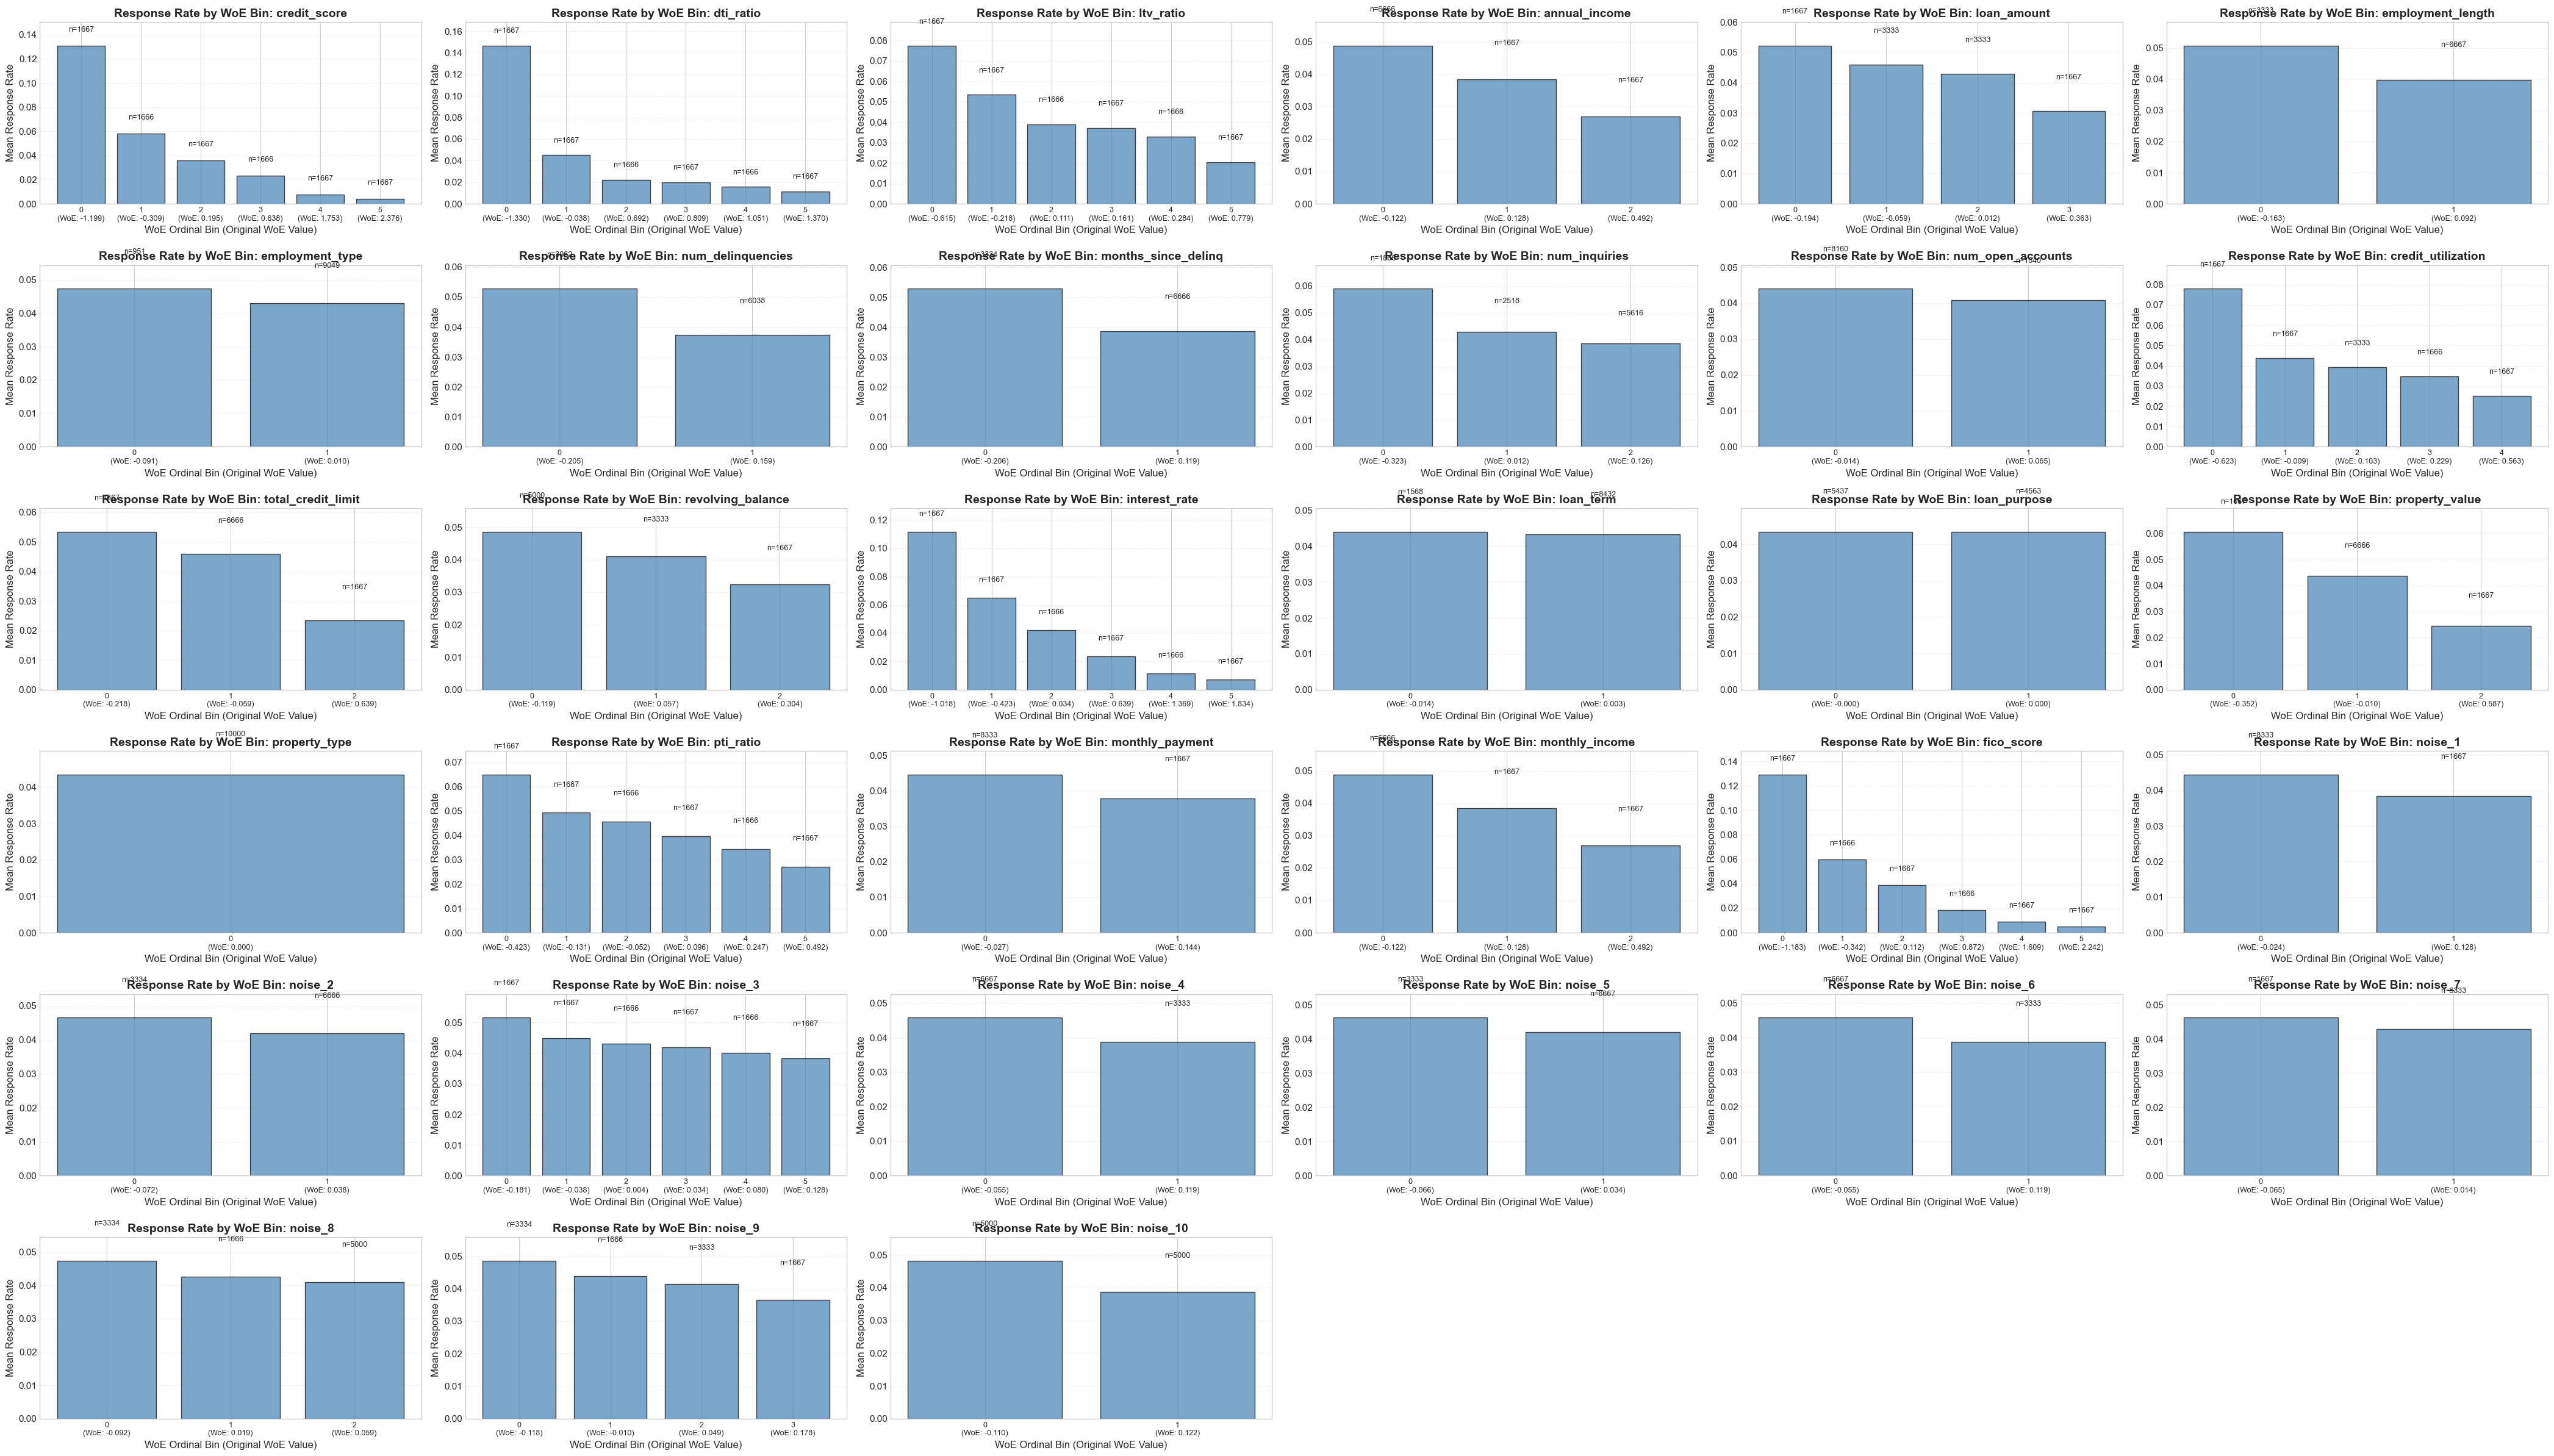

In [8]:
import sys
from sklearn.preprocessing import OrdinalEncoder
sys.path.insert(0, 'c:/Users/zjc10/OneDrive/Desktop/resources/code/variable_selection')
from variable_selection.woe_utils import WoEBinning , plot_woe_response_rates

#new dataframe to hold WoE transformed variables (will be used in variable selection)
X_woe = pd.DataFrame()

# WoE Binning with requirements
woe_binner = WoEBinning(min_bin_pct=0.02
                        , min_bins = 2
                        , max_bins=6, require_monotonic=True)

# Fit and transform each column
for col in X.columns:
    X_woe[col] = woe_binner.fit_transform(X[col], pd.Series(y))

# Convert WoE values to ordinal ranks
ordinal_encoder = OrdinalEncoder()
X_woe[X.columns] = ordinal_encoder.fit_transform(X_woe[X.columns])


# Update the plotting loop
# Calculate grid dimensions
n_cols = len(X.columns)
n_rows = int(np.ceil(np.sqrt(n_cols)))
n_cols_grid = int(np.ceil(n_cols / n_rows))

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols_grid, figsize=(7*n_cols_grid, 4*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot each variable
for i, col in enumerate(X.columns):
    print(f"Mapping for {col}: {ordinal_encoder.categories_[i]}")
    
    # Plot with updated labels on the corresponding subplot
    plot_woe_response_rates(X, X_woe, y, col, ordinal_encoder, i, ax=axes[i])

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

---
## 4. Phase 2: Filter Methods

Apply univariate screening methods to get initial feature rankings.

### 4.1 Information Value (IV) Analysis

In [17]:
# Calculate IV for all features
iv_df = calculate_all_iv(X_woe, y, bins=10)

print("=" * 50)
print("INFORMATION VALUE RANKINGS")
print("=" * 50)
print(iv_df.head(30).to_string(index=False))

INFORMATION VALUE RANKINGS
            feature     iv            predictive_strength
       credit_score 1.0968 Suspicious (check for leakage)
         fico_score 1.0661 Suspicious (check for leakage)
          dti_ratio 0.9653 Suspicious (check for leakage)
      interest_rate 0.7945 Suspicious (check for leakage)
          ltv_ratio 0.1798                         Medium
 credit_utilization 0.1375                         Medium
          pti_ratio 0.0817                           Weak
     property_value 0.0678                           Weak
 total_credit_limit 0.0612                           Weak
     monthly_income 0.0441                           Weak
      annual_income 0.0441                           Weak
  num_delinquencies 0.0325                           Weak
      num_inquiries 0.0313                           Weak
        loan_amount 0.0263                           Weak
months_since_delinq 0.0246                           Weak
  revolving_balance 0.0213                   

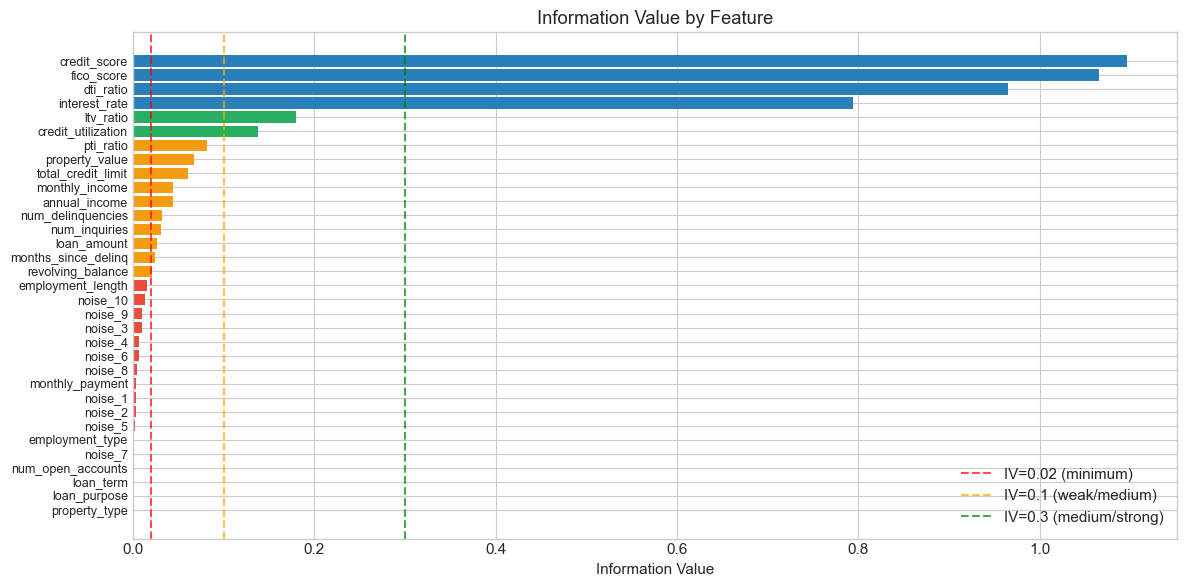


Summary:
  Not predictive (IV < 0.02): 17 features
  Weak (0.02 ≤ IV < 0.1): 10 features
  Medium (0.1 ≤ IV < 0.3): 2 features
  Strong (IV ≥ 0.3): 4 features


In [18]:
# Visualize IV distribution
fig, ax = plt.subplots(figsize=(12, 6))

# Color by predictive strength
colors = []
for iv in iv_df['iv']:
    if iv < 0.02:
        colors.append('#e74c3c')  # Red - not predictive
    elif iv < 0.1:
        colors.append('#f39c12')  # Orange - weak
    elif iv < 0.3:
        colors.append('#27ae60')  # Green - medium
    else:
        colors.append('#2980b9')  # Blue - strong

bars = ax.barh(range(len(iv_df)), iv_df['iv'], color=colors)
ax.set_yticks(range(len(iv_df)))
ax.set_yticklabels(iv_df['feature'], fontsize=9)
ax.set_xlabel('Information Value')
ax.set_title('Information Value by Feature')
ax.axvline(x=0.02, color='red', linestyle='--', alpha=0.7, label='IV=0.02 (minimum)')
ax.axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='IV=0.1 (weak/medium)')
ax.axvline(x=0.3, color='green', linestyle='--', alpha=0.7, label='IV=0.3 (medium/strong)')
ax.legend(loc='lower right')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Summary
print(f"\nSummary:")
print(f"  Not predictive (IV < 0.02): {(iv_df['iv'] < 0.02).sum()} features")
print(f"  Weak (0.02 ≤ IV < 0.1): {((iv_df['iv'] >= 0.02) & (iv_df['iv'] < 0.1)).sum()} features")
print(f"  Medium (0.1 ≤ IV < 0.3): {((iv_df['iv'] >= 0.1) & (iv_df['iv'] < 0.3)).sum()} features")
print(f"  Strong (IV ≥ 0.3): {(iv_df['iv'] >= 0.3).sum()} features")

### 4.2 Mutual Information Analysis

- MI = 0: feature and target are independent (no relationship)
- MI > 0: feature proves some information about target (higher values = stronger relationship)

Note: MI does not have fixed upper bound, scores should be compared relative to each other 

In [19]:
# Calculate Mutual Information
mi_df = calculate_mutual_information(X_woe, y, random_state=RANDOM_STATE)

print("=" * 50)
print("MUTUAL INFORMATION RANKINGS")
print("=" * 50)
print(mi_df.head(15).to_string(index=False))

MUTUAL INFORMATION RANKINGS
           feature  mutual_information
      credit_score              0.0246
         dti_ratio              0.0216
        fico_score              0.0182
     interest_rate              0.0144
           noise_9              0.0049
credit_utilization              0.0045
total_credit_limit              0.0045
         ltv_ratio              0.0044
           noise_8              0.0042
           noise_6              0.0042
 num_delinquencies              0.0041
          noise_10              0.0040
      loan_purpose              0.0031
     num_inquiries              0.0027
           noise_2              0.0026


### 4.3 Correlation Analysis & Multicollinearity

In [20]:
# Identify highly correlated pairs
corr_matrix, high_corr_pairs = correlation_filter(X_woe, y, threshold=0.7)

print("=" * 50)
print("HIGH CORRELATION PAIRS (|r| > 0.7)")
print("=" * 50)
if high_corr_pairs:
    for f1, f2, corr in sorted(high_corr_pairs, key=lambda x: -x[2]):
        print(f"  {f1} ↔ {f2}: r = {corr:.3f}")
else:
    print("  No highly correlated pairs found.")
    
high_corr_pairs

HIGH CORRELATION PAIRS (|r| > 0.7)
  annual_income ↔ monthly_income: r = 1.000
  credit_score ↔ fico_score: r = 0.986
  num_delinquencies ↔ months_since_delinq: r = 0.873
  credit_score ↔ interest_rate: r = 0.812
  interest_rate ↔ fico_score: r = 0.810
  loan_amount ↔ property_value: r = 0.805


[('credit_score', 'interest_rate', np.float64(0.8122043257189043)),
 ('credit_score', 'fico_score', np.float64(0.9860473088311548)),
 ('annual_income', 'monthly_income', np.float64(1.0)),
 ('loan_amount', 'property_value', np.float64(0.8052580139149608)),
 ('num_delinquencies', 'months_since_delinq', np.float64(0.8730506938477467)),
 ('interest_rate', 'fico_score', np.float64(0.8103531087087836))]

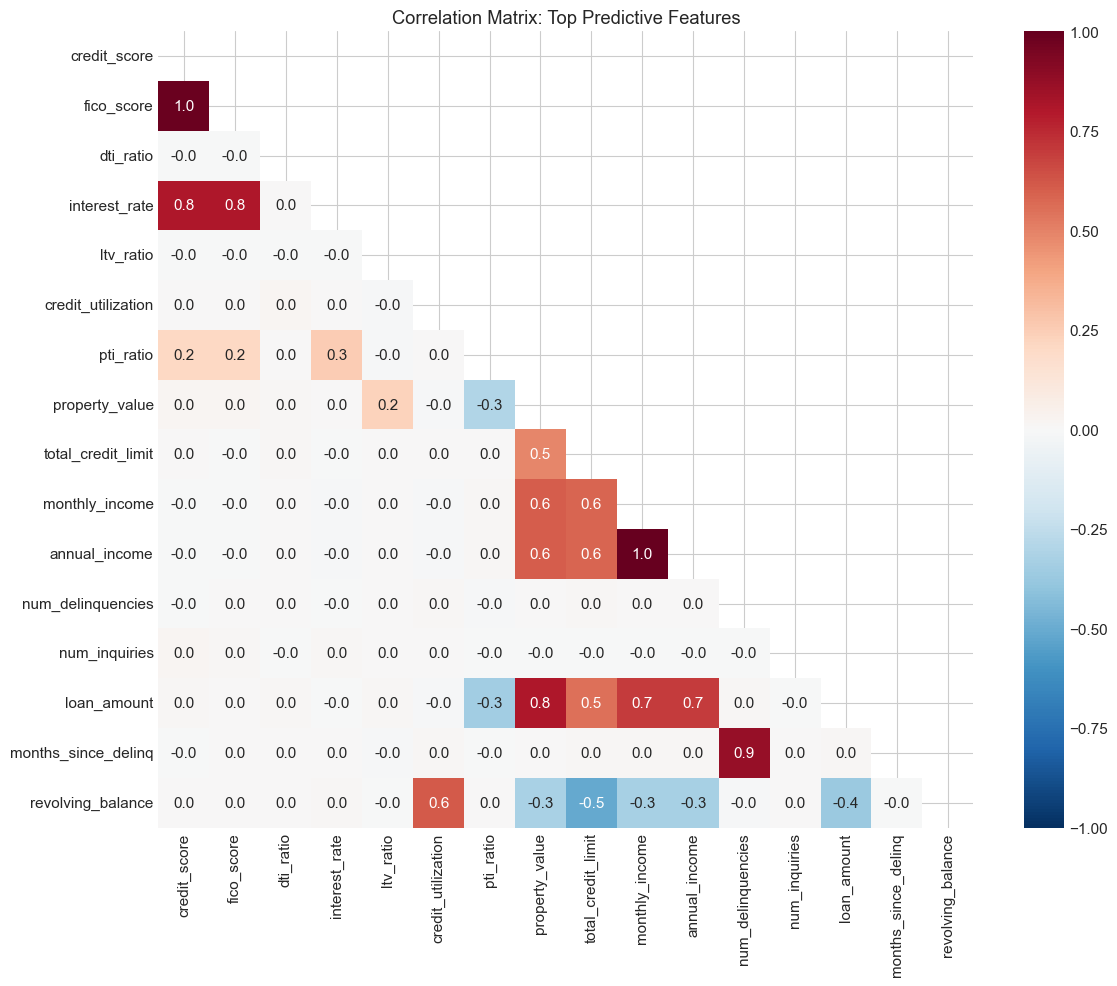

In [22]:
# Correlation heatmap for top predictive features
top_features = iv_df[iv_df['iv'] >= 0.02]['feature'].tolist()

if len(top_features) > 1:
    fig, ax = plt.subplots(figsize=(12, 10))
    corr_subset = X_woe[top_features].corr()
    mask = np.triu(np.ones_like(corr_subset, dtype=bool))
    sns.heatmap(corr_subset, mask=mask, annot=True, fmt='.1f', 
                cmap='RdBu_r', center=0, ax=ax, vmin=-1, vmax=1)
    ax.set_title('Correlation Matrix: Top Predictive Features')
    plt.tight_layout()
    plt.show()

In [23]:

### Manually Remove higly collinear vairables based on there correolation with target (pick the one that has the greatest corrolation with target)

# Calculate absolute correlation between each feature and the target
feature_target_corr = X_woe.corrwith(pd.Series(y)).abs().sort_values(ascending=False)
print("Absolute correlation of each feature with the target:")
print(feature_target_corr)


# Update high_corr_pairs to include correlation with target for each variable in the pair
# NOTE: USE THIS INFORMATION TO MANUALLY SELECT WHICH OF THE HIGHLY CORRELATED VARIABLES TO REMOVE AND WHICH TO RETAIN (RETAIN THE ONES WITH THE HIGHEST CORRELATION TO THE TARGET)
high_corr_pairs_with_target = []
for f1, f2, corr in high_corr_pairs:
    corr_f1_target = feature_target_corr.get(f1, np.nan)
    corr_f2_target = feature_target_corr.get(f2, np.nan)
    high_corr_pairs_with_target.append({
        'feature_1': f1,
        'feature_2': f2,
        'pair_corr': corr,
        'feature_1_target_corr': corr_f1_target,
        'feature_2_target_corr': corr_f2_target
    })

# Display as DataFrame for easier review
high_corr_pairs_df = pd.DataFrame(high_corr_pairs_with_target)
print("Highly correlated pairs with their correlation to the target:")
display(high_corr_pairs_df.sort_values('pair_corr', ascending=False))

Absolute correlation of each feature with the target:
credit_score          0.1908
fico_score            0.1902
dti_ratio             0.1833
interest_rate         0.1678
ltv_ratio             0.0833
credit_utilization    0.0726
pti_ratio             0.0575
property_value        0.0510
total_credit_limit    0.0425
monthly_income        0.0405
annual_income         0.0405
num_delinquencies     0.0372
num_inquiries         0.0357
months_since_delinq   0.0326
loan_amount           0.0302
revolving_balance     0.0292
employment_length     0.0253
noise_10              0.0236
noise_9               0.0207
noise_3               0.0195
noise_6               0.0163
noise_4               0.0163
noise_8               0.0138
monthly_payment       0.0123
noise_1               0.0110
noise_2               0.0107
noise_5               0.0097
employment_type       0.0062
num_open_accounts     0.0062
noise_7               0.0061
loan_term             0.0013
loan_purpose          0.0000
property_type     

,feature_1,feature_2,pair_corr,feature_1_target_corr,feature_2_target_corr
2,annual_income,monthly_income,1.0000,0.0405,0.0405
1,credit_score,fico_score,0.9860,0.1908,0.1902
4,num_delinquencies,months_since_delinq,0.8731,0.0372,0.0326
0,credit_score,interest_rate,0.8122,0.1908,0.1678
5,interest_rate,fico_score,0.8104,0.1678,0.1902
3,loan_amount,property_value,0.8053,0.0302,0.0510


### 4.4 Variance Inflation Factor (VIF) Analysis

In [24]:
# Calculate VIF for all features
vif_df = calculate_vif(X_woe)

print("=" * 50)
print("VARIANCE INFLATION FACTOR (VIF)")
print("=" * 50)
print(f"Features with VIF > 10: {(vif_df['vif'] > 10).sum()}")
print(f"Features with VIF > 5: {(vif_df['vif'] > 5).sum()}")
print(f"\nTop 10 by VIF:")
print(vif_df.head(10).to_string(index=False))
vif_df

##update high_corr_pairs_df to include VIF values for each variable in the pair
# Add VIF values for each variable in the pair
vif_map = dict(zip(vif_df['feature'], vif_df['vif']))
high_corr_pairs_df['feature_1_vif'] = high_corr_pairs_df['feature_1'].map(vif_map)
high_corr_pairs_df['feature_2_vif'] = high_corr_pairs_df['feature_2'].map(vif_map)

display(high_corr_pairs_df.sort_values('pair_corr', ascending=False))

VARIANCE INFLATION FACTOR (VIF)
Features with VIF > 10: 8
Features with VIF > 5: 15

Top 10 by VIF:
            feature      vif
      annual_income      inf
     monthly_income      inf
       credit_score 115.7921
         fico_score 114.7890
        loan_amount  15.7202
     property_value  14.0159
months_since_delinq  12.5540
  num_delinquencies  10.6525
      interest_rate   9.7405
    employment_type   8.7827


,feature_1,feature_2,pair_corr,feature_1_target_corr,feature_2_target_corr,feature_1_vif,feature_2_vif
2,annual_income,monthly_income,1.0000,0.0405,0.0405,inf,inf
1,credit_score,fico_score,0.9860,0.1908,0.1902,115.7921,114.7890
4,num_delinquencies,months_since_delinq,0.8731,0.0372,0.0326,10.6525,12.5540
0,credit_score,interest_rate,0.8122,0.1908,0.1678,115.7921,9.7405
5,interest_rate,fico_score,0.8104,0.1678,0.1902,9.7405,114.7890
3,loan_amount,property_value,0.8053,0.0302,0.0510,15.7202,14.0159


In [ ]:
# Iteratively remove high-VIF features
print("\n" + "=" * 50)
print("ITERATIVE VIF ELIMINATION (threshold=5.0)")
print("=" * 50)

retained_features, removal_history = iterative_vif_elimination(X, threshold=10.0, verbose=True)

print(f"\nRetained {len(retained_features)} features after VIF elimination")
print(f"Removed {len(removal_history)} features")

In [ ]:
# Create VIF-filtered feature set for further analysis
X_vif_filtered = X[retained_features].copy()
print(f"VIF-filtered dataset shape: {X_vif_filtered.shape}")

---
## 5. Phase 3-4: Nested CV with Ensemble Variable Selection

This is the core of our variable selection process. We use nested cross-validation to:
1. Avoid information leakage in performance estimation
2. Run multiple selection methods in the inner loop
3. Aggregate selections via majority voting
4. Evaluate on truly held-out outer test folds

In [ ]:
# Define selection methods for the ensemble
selection_methods = {
    'LASSO': lasso_selection,
    'Elastic_Net': elastic_net_selection,
    'RFE': rfe_selection,
    'Forward': forward_selection,
    'MI': mutual_info_selection,
    'Tree_Importance': tree_importance_selection,
    'IV': iv_selection
}

print(f"Running {len(selection_methods)} selection methods:")
for name in selection_methods:
    print(f"  • {name}")

In [ ]:
# Initialize and run Nested CV
nested_cv = NestedCVVariableSelector(
    outer_cv=5,
    inner_cv=5,
    random_state=RANDOM_STATE,
    min_votes=4,  # Feature must be selected by at least 4 of 7 methods
    verbose=True
)

# Run the nested CV process (this takes a few minutes)
print("\nStarting Nested CV Variable Selection...")
print("(This may take 2-5 minutes depending on your hardware)\n")

nested_cv.fit(X_vif_filtered, y, selection_methods)

In [ ]:
# Get results summary
results_df, summary = nested_cv.get_results_summary()

print("\n" + "=" * 60)
print("NESTED CV RESULTS SUMMARY")
print("=" * 60)
print(f"\nPerformance (Outer Folds):")
print(f"  ROC-AUC: {summary['mean_roc_auc']:.4f} ± {summary['std_roc_auc']:.4f}")
print(f"  Brier Score: {summary['mean_brier']:.4f} ± {summary['std_brier']:.4f}")
print(f"  Log Loss: {summary['mean_log_loss']:.4f} ± {summary['std_log_loss']:.4f}")
print(f"\nVariable Selection:")
print(f"  Mean features selected: {summary['mean_n_features']:.1f}")
print(f"  Selection stability (Kuncheva): {summary['kuncheva_stability']:.3f}")
print(f"\nStability Assessment:")
print(f"  Features in ≥80% of folds: {nested_cv.feature_selection_stability_['n_stable_features_80']}")
print(f"  Features in ≥60% of folds: {nested_cv.feature_selection_stability_['n_stable_features_60']}")

In [ ]:
# Detailed fold-by-fold results
print("\nFold-by-Fold Results:")
print(results_df[['fold', 'n_features', 'roc_auc', 'brier_score']].to_string(index=False))

In [ ]:
# Visualize CV performance
fig, axes = plot_cv_performance(nested_cv, figsize=(12, 5))
plt.show()

In [ ]:
# Feature selection stability
feature_votes = nested_cv.get_feature_votes()

print("\n" + "=" * 60)
print("FEATURE SELECTION STABILITY")
print("=" * 60)
print(feature_votes.head(20).to_string(index=False))

In [ ]:
# Visualize stability
fig, ax = plot_stability_across_folds(nested_cv, top_n=20, figsize=(10, 8))
plt.show()

---
## 6. Phase 5: Final Variable Set Selection

Based on stability analysis, we select features that were consistently chosen across CV folds.

In [ ]:
# Get stable features (selected in ≥80% of folds)
stable_features_80 = nested_cv.get_stable_features(threshold=0.8)
stable_features_60 = nested_cv.get_stable_features(threshold=0.6)

print("=" * 60)
print("STABLE FEATURE SETS")
print("=" * 60)
print(f"\n80% Stability Threshold ({len(stable_features_80)} features):")
for f in stable_features_80:
    freq = nested_cv.feature_selection_stability_['feature_frequencies'][f]
    print(f"  • {f} ({freq:.0%})")

print(f"\n60% Stability Threshold ({len(stable_features_60)} features):")
for f in stable_features_60:
    freq = nested_cv.feature_selection_stability_['feature_frequencies'][f]
    print(f"  • {f} ({freq:.0%})")

In [ ]:
# Select final feature set
# Use 60% threshold if 80% gives too few features
if len(stable_features_80) >= 5:
    final_features = stable_features_80
    stability_threshold = 0.8
else:
    final_features = stable_features_60
    stability_threshold = 0.6

print(f"\nFinal feature set ({len(final_features)} features, {stability_threshold:.0%} threshold):")
print(final_features)

---
## 7. Phase 6: Assumption Validation on Final Feature Set

Validate that the final variable set satisfies logistic regression assumptions.

### 7.1 VIF Check on Final Features

In [ ]:
# VIF on final feature set
X_final = X[final_features]
vif_final = calculate_vif(X_final)

print("=" * 60)
print("VIF CHECK ON FINAL FEATURES")
print("=" * 60)
print(vif_final.to_string(index=False))
print(f"\nMax VIF: {vif_final['vif'].max():.2f}")
print(f"All VIF < 5: {'✓ PASS' if (vif_final['vif'] < 5).all() else '✗ FAIL'}")

### 7.2 Linearity in Logit (Box-Tidwell Test)

In [ ]:
# Identify continuous variables in final set
continuous_vars = [col for col in final_features 
                   if X_final[col].nunique() > 10 and X_final[col].min() > 0]

if continuous_vars:
    print("=" * 60)
    print("BOX-TIDWELL TEST FOR LINEARITY IN LOGIT")
    print("=" * 60)
    
    bt_results = box_tidwell_test(X_final, y, continuous_vars)
    print(bt_results.to_string(index=False))
    
    n_nonlinear = (bt_results['linearity_holds'] == False).sum()
    print(f"\nVariables with potential non-linearity: {n_nonlinear}")
    if n_nonlinear > 0:
        print("Consider transformations (log, sqrt, binning) for these variables.")
else:
    print("No continuous positive variables for Box-Tidwell test.")

### 7.3 EPV Check on Final Features

In [ ]:
# EPV on final feature set
epv_final = calculate_epv(y, len(final_features))

print("=" * 60)
print("EPV CHECK ON FINAL FEATURES")
print("=" * 60)
print(f"Number of features: {len(final_features)}")
print(f"EPV Ratio: {epv_final['epv_ratio']:.2f}")
print(f"Meets EPV ≥ 10: {'✓ PASS' if epv_final['meets_minimum_10'] else '✗ FAIL'}")
print(f"Meets EPV ≥ 20: {'✓ PASS' if epv_final['meets_robust_20'] else '✗ CAUTION'}")

---
## 8. Phase 7: Final Model Diagnostics

Fit the final model and run comprehensive diagnostics.

In [ ]:
# Run comprehensive diagnostics
diagnostics = final_model_diagnostics(
    X, y, 
    feature_names=final_features,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("=" * 60)
print("FINAL MODEL DIAGNOSTICS")
print("=" * 60)
print(f"\nModel Convergence: {'✓ YES' if diagnostics['model_converged'] else '✗ NO'}")
print(f"Number of Features: {diagnostics['n_features']}")
print(f"EPV Ratio: {diagnostics['epv_ratio']:.2f}")

print(f"\nPerformance Metrics:")
print(f"  Train ROC-AUC: {diagnostics['train_roc_auc']:.4f}")
print(f"  Test ROC-AUC: {diagnostics['test_roc_auc']:.4f}")
print(f"  AUC Gap (overfitting check): {diagnostics['auc_gap']:.4f}")
print(f"  Train Brier Score: {diagnostics['train_brier']:.4f}")
print(f"  Test Brier Score: {diagnostics['test_brier']:.4f}")

print(f"\nModel Statistics:")
print(f"  Pseudo R²: {diagnostics['pseudo_r2']:.4f}")
print(f"  AIC: {diagnostics['aic']:.2f}")
print(f"  BIC: {diagnostics['bic']:.2f}")

print(f"\nMulticollinearity Check:")
print(f"  Max VIF: {diagnostics['max_vif']:.2f}")
print(f"  All VIF < 5: {'✓ PASS' if diagnostics['all_vif_below_5'] else '✗ FAIL'}")

In [ ]:
# Coefficient summary
print("\n" + "=" * 60)
print("COEFFICIENT SUMMARY")
print("=" * 60)
coef_df = diagnostics['coefficients']
print(coef_df.to_string(index=False))

In [ ]:
# Visualize coefficients
fig, ax = plt.subplots(figsize=(10, 6))

# Exclude constant
coef_plot = coef_df[coef_df['feature'] != 'const'].copy()
coef_plot = coef_plot.sort_values('coef')

colors = ['#e74c3c' if p < 0.05 else '#95a5a6' for p in coef_plot['p_value']]
ax.barh(range(len(coef_plot)), coef_plot['coef'], color=colors)
ax.set_yticks(range(len(coef_plot)))
ax.set_yticklabels(coef_plot['feature'])
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Coefficient (Standardized)')
ax.set_title('Logistic Regression Coefficients\n(Red = significant at p<0.05)')
plt.tight_layout()
plt.show()

---
## 9. Summary & Recommendations

In [ ]:
print("=" * 70)
print("VARIABLE SELECTION SUMMARY REPORT")
print("=" * 70)

print(f"\n1. INITIAL DATASET")
print(f"   • Samples: {N_SAMPLES:,}")
print(f"   • Initial features: {X.shape[1]}")
print(f"   • Default rate: {y.mean():.2%}")

print(f"\n2. PRE-PROCESSING")
print(f"   • Features after VIF elimination: {len(retained_features)}")
print(f"   • High-IV features (IV ≥ 0.02): {(iv_df['iv'] >= 0.02).sum()}")

print(f"\n3. NESTED CV RESULTS")
print(f"   • Outer folds: {nested_cv.outer_cv}")
print(f"   • Inner folds: {nested_cv.inner_cv}")
print(f"   • Selection methods: {len(selection_methods)}")
print(f"   • Min votes for consensus: {nested_cv.min_votes}")
print(f"   • Mean ROC-AUC: {summary['mean_roc_auc']:.4f} ± {summary['std_roc_auc']:.4f}")
print(f"   • Kuncheva stability: {summary['kuncheva_stability']:.3f}")

print(f"\n4. FINAL VARIABLE SET")
print(f"   • Features selected: {len(final_features)}")
print(f"   • Stability threshold: {stability_threshold:.0%}")
print(f"   • Features: {final_features}")

print(f"\n5. ASSUMPTION VALIDATION")
print(f"   • EPV ratio: {epv_final['epv_ratio']:.1f} {'✓' if epv_final['meets_minimum_10'] else '✗'}")
print(f"   • Max VIF: {diagnostics['max_vif']:.2f} {'✓' if diagnostics['all_vif_below_5'] else '✗'}")
print(f"   • Model converged: {'✓' if diagnostics['model_converged'] else '✗'}")

print(f"\n6. FINAL MODEL PERFORMANCE")
print(f"   • Test ROC-AUC: {diagnostics['test_roc_auc']:.4f}")
print(f"   • Test Brier Score: {diagnostics['test_brier']:.4f}")
print(f"   • Overfitting (AUC gap): {diagnostics['auc_gap']:.4f}")

print("\n" + "=" * 70)
print("RECOMMENDATIONS")
print("=" * 70)

recommendations = []
if diagnostics['auc_gap'] > 0.05:
    recommendations.append("• Consider stronger regularization - AUC gap suggests overfitting")
if not diagnostics['all_vif_below_5']:
    recommendations.append("• Review multicollinearity - some VIF values exceed threshold")
if not epv_final['meets_robust_20']:
    recommendations.append("• Consider reducing features or collecting more data for robust EPV")
if summary['kuncheva_stability'] < 0.6:
    recommendations.append("• Selection stability is low - interpret coefficients cautiously")

if recommendations:
    for rec in recommendations:
        print(rec)
else:
    print("• All diagnostics pass - model appears well-specified")
    print("• Consider domain expert review before production deployment")

In [ ]:
# Save final results
results_output = {
    'final_features': final_features,
    'nested_cv_summary': summary,
    'feature_stability': nested_cv.get_feature_votes().to_dict('records'),
    'diagnostics': {
        'test_roc_auc': diagnostics['test_roc_auc'],
        'test_brier': diagnostics['test_brier'],
        'epv_ratio': diagnostics['epv_ratio'],
        'max_vif': diagnostics['max_vif']
    }
}

print("\nFinal selected features for production model:")
print(final_features)

---
## Appendix: Method Comparison Across Folds

In [ ]:
# Show which features each method selected in each fold
print("=" * 70)
print("METHOD SELECTION DETAILS BY FOLD")
print("=" * 70)

for fold_idx, fold_selections in enumerate(nested_cv.method_selections_per_fold_):
    print(f"\n--- Outer Fold {fold_idx + 1} ---")
    for method_name, features in fold_selections.items():
        print(f"  {method_name}: {len(features)} features")

In [ ]:
# Aggregate method comparison
method_feature_counts = {}
for fold_selections in nested_cv.method_selections_per_fold_:
    for method, features in fold_selections.items():
        if method not in method_feature_counts:
            method_feature_counts[method] = []
        method_feature_counts[method].append(len(features))

print("\nAverage Features Selected by Method:")
for method, counts in method_feature_counts.items():
    print(f"  {method}: {np.mean(counts):.1f} ± {np.std(counts):.1f}")